# Feature selection using genetic algorithm

In [28]:
import seaborn as sns
%matplotlib inline
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statistics as stat
import time
import warnings
warnings.filterwarnings('ignore')

In [24]:
cols=feature=[#'IP_id',
#'ICMP_chksum',
#'ICMP_id',
#'TCP_seq',
#'TCP_ack',
 #'TCP_chksum',
# 'UDP_chksum',
# 'DNS_id',
# 'BOOTP_xid',
'sport_class',
'dport_class',
#'sport23',
#'dport23',
#'sport_bare',
# 'dport_bare',
# 'TCP_sport',
# 'TCP_dport',
# 'UDP_sport',
# 'UDP_dport',
 'pck_size',
 'Ether_type',
 'LLC_ssap',
 'LLC_ctrl',
 'EAPOL_version',
 'EAPOL_type',
 'EAPOL_len',
 'IP_version',
 'IP_ihl',
 'IP_tos',
 'IP_len',
 'IP_flags',
 'IP_DF',
 'IP_ttl',
 'IP_proto',
 'IP_options',
 'ICMP_type',
 'ICMP_code',
 'ICMP_seq',
 'TCP_dataofs',
 'TCP_flags',
 'TCP_FIN',
 'TCP_SYN',
 'TCP_RST',
 'TCP_PSH',
 'TCP_ACK',
 'TCP_window',
 'TCP_options',
 'UDP_len',
 'DHCP_options',
 'BOOTP_op',
 'BOOTP_htype',
 'BOOTP_hlen',
 'BOOTP_secs',
 'BOOTP_flags',
 'BOOTP_sname',
 'BOOTP_file',
 'BOOTP_options',
 'DNS_qr',
 'DNS_aa',
 'DNS_rd',
 'DNS_ra',
 'DNS_rcode',
 'DNS_qdcount',
 'DNS_ancount',
 'DNS_nscount',
 'DNS_arcount',
 'payload_bytes',    
 'entropy',
 'Protocol',
#"MAC",
 'Label']



In [25]:
len(cols)

53

In [26]:
test='./Aalto_test_IoTDevID.csv'
train='./Aalto_train_IoTDevID.csv'

df = pd.read_csv(train,usecols=cols)#,header=None )

X_train =df[df.columns[0:-1]]
#X_train=np.array(X_train)
df[df.columns[-1]] = df[df.columns[-1]].astype('category')
y_train=df[df.columns[-1]].cat.codes  



df = pd.read_csv(test,usecols=cols)#,header=None )

X_test =df[df.columns[0:-1]]
#X_test=np.array(X_test)
df[df.columns[-1]] = df[df.columns[-1]].astype('category')
y_test=df[df.columns[-1]].cat.codes  


print(X_train.shape,
X_test.shape,
y_train.shape,
y_test.shape ,)

(83894, 52) (21182, 52) (83894,) (21182,)


In [27]:
#training a logistics regression model
logmodel = DecisionTreeClassifier()
results=[]

#print("Accuracy = "+ str(accuracy_score(y_test,predictions)))
for i in range(100):
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)
    results.append(f1_score(y_test,predictions,average= "macro"))
print ('%-30s %-30s' % ("MEAN","STD"))
print ('%-30s %-30s' % (np.mean(results),np.std(results)))

MEAN                           STD                           
0.7004572162089037             0.0007499143077558713         


In [10]:
#defining various steps required for the genetic algorithm
# GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],y_train)
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(f1_score(y_test,predictions,average= "macro"))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        second=time.time()
        scores, pop_after_fit = fitness_score(population_nextgen)
        #print(scores[:2])
        zaman=time.time()-second
        print ('%-30s %-30s %-30s' % (np.mean(scores),np.std(scores),zaman))

        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [13]:
print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))


chromo,score=generations(size=200,n_feat=52,n_parents=120,mutation_rate=0.005,
                     n_gen=100,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
print("F1 Score score after genetic algorithm is= "+str(f1_score(y_test,predictions,average= "macro")))

MEAN                           STD                            TIME                          
0.6589763227659767             0.0467366271654974             72.50790762901306             
0.6903423841259091             0.016978390471161325           92.58118104934692             
0.7037734697205251             0.012562650137698778           92.41869306564331             
0.7105832007412997             0.01039437973573768            81.27631998062134             
0.7151130877930377             0.011284655381154373           83.58070492744446             
0.7163302023674766             0.00934232260986502            82.44272685050964             
0.7158258343516155             0.014617278538779392           83.65655159950256             
0.7171012067704591             0.011017212047898756           80.1672351360321              
0.7147308453850421             0.019049716987980664           80.54223108291626             
0.7171476267661043             0.016029285062235776           82.71649

0.720159135049198              0.006159985321391933           81.93549752235413             
0.7178453371019254             0.016685563926721547           82.1031243801117              
0.7200585927404771             0.007018993336421349           82.51801180839539             
0.7209126406396161             0.004315895123713204           81.6044590473175              
0.7195324798059186             0.010547422597837572           82.67063403129578             
0.7200382115479268             0.007469305010173104           82.17299580574036             
0.7203845894772577             0.009102790438128831           83.07358241081238             
0.7209306296831303             0.00419504130794055            83.71685886383057             
0.7190722448147076             0.013491507915830085           87.70822548866272             
0.7206276278989598             0.005709347004996504           88.8571527004242              
0.7183922899461342             0.015985182457113604           86.20724

In [14]:
results=[]
for i in range(10):
    logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    results.append(f1_score(y_test,predictions,average= "macro"))
print ('%-30s %-30s' % ("MEAN","STD"))
print ('%-30s %-30s' % (np.mean(results),np.std(results)))

MEAN                           STD                           
0.7215949485256491             0.0001474021994194392         


In [15]:
chromo

[array([False,  True, False,  True,  True, False,  True,  True, False,
         True,  True, False,  True,  True,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True, False, False,
         True,  True, False,  True,  True,  True, False]),
 array([False,  True, False,  True,  True, False,  True,  True, False,
         True,  True, False,  True,  True,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False, False,
         True,  True, False,  True,  True,  True, False]),
 array([ True,  True,  True,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True, False,  True, False,  True,
        False,  True,  True,  

In [16]:
sonuç=[]
for j in chromo:
    temp=X_train.iloc[:,j]
    temp=list(temp.columns)
    temp.append("Label")
    sonuç.append(temp)
print(sonuç)

[['Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_version', 'IP_tos', 'IP_len', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_RST', 'TCP_PSH', 'TCP_window', 'TCP_options', 'UDP_len', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Label'], ['Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_version', 'IP_tos', 'IP_len', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_RST', 'TCP_PSH', 'TCP_window', 'TCP_options', 'UDP_len', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Label'], ['pck_size', 'Ether_typ

In [17]:
results=[]
for i in range(10):
    logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    results.append(f1_score(y_test,predictions,average= "macro"))
print ('%-30s %-30s' % ("MEAN","STD"))
print ('%-30s %-30s' % (np.mean(results),np.std(results)))

MEAN                           STD                           
0.7216485209683412             0.00017206169854589853        


# Comparison of GA results

In [1]:
import pandas as pd
import seaborn as sns
from  MLs import ML, find_the_way
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [11]:
test='./Aalto_test_IoTDevID.csv'
train='./Aalto_train_IoTDevID.csv'
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
features=[['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_flags', 'TCP_FIN', 'TCP_window', 'TCP_options', 'UDP_len', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_type', 'IP_version', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_flags', 'TCP_SYN', 'TCP_PSH', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_op', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_qdcount', 'DNS_nscount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_flags', 'TCP_FIN', 'TCP_window', 'TCP_options', 'UDP_len', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_len', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_file', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_version', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen',
'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_arcount', 'sport_class', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_PSH', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_ihl', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_PSH', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_file', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_file', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_PSH', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_file', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_DF', 'IP_ttl', 'ICMP_type', 'ICMP_seq', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_rd', 'DNS_ra', 'DNS_rcode', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_PSH', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_file', 'DNS_qr', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_PSH', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_version', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_PSH', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl',
'EAPOL_version', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_PSH', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_file', 'DNS_qr', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_PSH', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_len', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_options', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_ancount', 'DNS_nscount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_aa', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'ICMP_type', 'ICMP_code', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_PSH', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_sname', 'BOOTP_file', 'DNS_qr', 'DNS_aa', 'DNS_rd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label'], ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_tos', 'IP_flags', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_seq', 'TCP_dataofs', 'TCP_flags', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_ACK', 'TCP_window', 'DHCP_options', 'BOOTP_op', 'BOOTP_hlen', 'BOOTP_secs', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_ra', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_arcount', 'dport_class', 'payload_bytes', 'entropy', 'Protocol', 'Label']]

step=1
mixed=False
dataset="./Aalto/False/"#dataset[2:-1]+"_"+str(step)
ml_list={"DT" :DecisionTreeClassifier()}
cm=False
repetition=10






for sayac,feature in enumerate(features):
    output_csv="./100/"+str(sayac)+"_"+str(len(feature))+".csv"
    dataset=str(sayac)+"__"+str(len(feature))
    feature.insert(0,"MAC")
    ML(train,test,output_csv,feature,step,mixed,dataset,ml_list,cm,repetition)  
 

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
0__39           0   1   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.21     0.0     0.21    0.0     
0__39           1   2   DT      0.7   0.7   0.76  0.7   0.7214   0.67  0.21     0.01    0.22    0.0     
0__39           2   3   DT      0.7   0.7   0.76  0.7   0.7214   0.67  0.23     0.01    0.24    0.0     
0__39           3   4   DT      0.7   0.7   0.76  0.7   0.7209   0.67  0.22     0.02    0.24    0.0     
0__39           4   5   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.22     0.0     0.22    0.0     
0__39           5   6   DT      0.7   0.7   0.76  0.7   0.7215   0.67  0.22     0.0     0.22    0.0     
0__39           6   7   DT      0.7   0.7   0.76  0.7   0.7215   0.68  0.22     0.01    0.24    0.0     
0__39           7   8   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.24     0.01    0.25    0.0     
0__39           8   9   DT      0.7   0.7   0.76  0.7  

7__37           1   2   DT      0.7   0.7   0.76  0.7   0.7214   0.67  0.2      0.01    0.21    0.0     
7__37           2   3   DT      0.7   0.7   0.76  0.7   0.7216   0.67  0.19     0.01    0.2     0.0     
7__37           3   4   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.21     0.0     0.21    0.0     
7__37           4   5   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.21     0.01    0.22    0.0     
7__37           5   6   DT      0.7   0.7   0.76  0.7   0.7211   0.67  0.21     0.0     0.21    0.0     
7__37           6   7   DT      0.7   0.7   0.76  0.7   0.7212   0.68  0.2      0.0     0.2     0.0     
7__37           7   8   DT      0.7   0.7   0.76  0.7   0.7215   0.68  0.2      0.0     0.2     0.0     
7__37           8   9   DT      0.7   0.7   0.76  0.7   0.7215   0.68  0.19     0.01    0.2     0.0     
7__37           9   10  DT      0.7   0.7   0.76  0.7   0.7213   0.67  0.21     0.01    0.22    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec  

14__40          3   4   DT      0.7   0.7   0.75  0.7   0.7142   0.67  0.2      0.0     0.2     0.0     
14__40          4   5   DT      0.7   0.7   0.75  0.7   0.714    0.67  0.2      0.0     0.2     0.0     
14__40          5   6   DT      0.7   0.7   0.75  0.7   0.7138   0.67  0.19     0.01    0.2     0.0     
14__40          6   7   DT      0.7   0.7   0.75  0.7   0.7134   0.67  0.19     0.01    0.2     0.0     
14__40          7   8   DT      0.7   0.7   0.75  0.7   0.7141   0.67  0.2      0.0     0.2     0.0     
14__40          8   9   DT      0.7   0.7   0.75  0.7   0.7142   0.67  0.2      0.0     0.2     0.0     
14__40          9   10  DT      0.7   0.7   0.75  0.7   0.714    0.67  0.19     0.01    0.2     0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
15__36          0   1   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.19     0.01    0.2     0.0     
15__36          1   2   DT      0.7   0.7   0.76  0.7  

21__32          5   6   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.01    0.2     0.0     
21__32          6   7   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.18     0.01    0.19    0.0     
21__32          7   8   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.0     0.19    0.0     
21__32          8   9   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.18     0.01    0.19    0.0     
21__32          9   10  DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.19     0.0     0.19    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
22__37          0   1   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.2      0.01    0.21    0.0     
22__37          1   2   DT      0.7   0.7   0.76  0.7   0.7212   0.68  0.22     0.0     0.22    0.0     
22__37          2   3   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.19     0.0     0.19    0.0     
22__37          3   4   DT      0.7   0.7   0.76  0.7  

28__37          7   8   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.01    0.21    0.0     
28__37          8   9   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.21     0.01    0.22    0.0     
28__37          9   10  DT      0.7   0.7   0.76  0.7   0.7219   0.68  0.2      0.01    0.21    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
29__34          0   1   DT      0.7   0.7   0.76  0.7   0.7219   0.68  0.19     0.0     0.19    0.0     
29__34          1   2   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.01    0.2     0.0     
29__34          2   3   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.01    0.21    0.0     
29__34          3   4   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.23     0.0     0.24    0.0     
29__34          4   5   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.22     0.01    0.23    0.0     
29__34          5   6   DT      0.7   0.7   0.76  0.7  

35__36          9   10  DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.21     0.01    0.21    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
36__33          0   1   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.22     0.01    0.23    0.0     
36__33          1   2   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.29     0.01    0.29    0.0     
36__33          2   3   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.02    0.21    0.0     
36__33          3   4   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.18     0.02    0.2     0.0     
36__33          4   5   DT      0.7   0.7   0.76  0.7   0.7212   0.68  0.19     0.02    0.21    0.0     
36__33          5   6   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.02    0.22    0.0     
36__33          6   7   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.21     0.0     0.21    0.0     
36__33          7   8   DT      0.7   0.7   0.76  0.7  

43__36          0   1   DT      0.67  0.6   0.66  0.6   0.6124   0.63  0.13     0.01    0.14    0.0     
43__36          1   2   DT      0.67  0.6   0.66  0.6   0.6125   0.63  0.14     0.01    0.15    0.0     
43__36          2   3   DT      0.67  0.6   0.66  0.6   0.6125   0.63  0.14     0.01    0.14    0.0     
43__36          3   4   DT      0.67  0.6   0.66  0.6   0.6124   0.63  0.17     0.01    0.17    0.0     
43__36          4   5   DT      0.67  0.6   0.66  0.6   0.6124   0.63  0.14     0.01    0.15    0.0     
43__36          5   6   DT      0.67  0.6   0.66  0.6   0.6125   0.63  0.14     0.01    0.15    0.0     
43__36          6   7   DT      0.67  0.6   0.66  0.6   0.6124   0.63  0.14     0.01    0.15    0.0     
43__36          7   8   DT      0.67  0.6   0.66  0.6   0.6124   0.63  0.14     0.01    0.14    0.0     
43__36          8   9   DT      0.67  0.6   0.66  0.6   0.6124   0.63  0.14     0.01    0.14    0.0     
43__36          9   10  DT      0.67  0.6   0.66  0.6  

50__31          2   3   DT      0.68  0.65  0.73  0.65  0.6786   0.64  0.19     0.02    0.21    0.0     
50__31          3   4   DT      0.68  0.65  0.73  0.65  0.6788   0.64  0.32     0.01    0.33    0.0     
50__31          4   5   DT      0.68  0.65  0.73  0.65  0.6787   0.64  0.21     0.02    0.23    0.0     
50__31          5   6   DT      0.68  0.65  0.73  0.65  0.6787   0.64  0.22     0.01    0.22    0.0     
50__31          6   7   DT      0.68  0.65  0.73  0.65  0.6788   0.64  0.2      0.01    0.21    0.0     
50__31          7   8   DT      0.68  0.65  0.73  0.65  0.6787   0.64  0.2      0.0     0.2     0.0     
50__31          8   9   DT      0.68  0.65  0.73  0.65  0.6783   0.64  0.19     0.0     0.19    0.0     
50__31          9   10  DT      0.68  0.65  0.73  0.65  0.6788   0.64  0.18     0.0     0.18    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
51__36          0   1   DT      0.7   0.7   0.76  0.7  

57__34          4   5   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.2      0.0     0.2     0.0     
57__34          5   6   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.2      0.0     0.2     0.0     
57__34          6   7   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.27     0.02    0.29    0.0     
57__34          7   8   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.25     0.02    0.26    0.0     
57__34          8   9   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.24     0.01    0.26    0.0     
57__34          9   10  DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.21     0.0     0.21    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
58__34          0   1   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.02    0.2     0.0     
58__34          1   2   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.2      0.0     0.2     0.0     
58__34          2   3   DT      0.7   0.7   0.76  0.7  

64__36          6   7   DT      0.7   0.7   0.76  0.7   0.7212   0.67  0.19     0.01    0.2     0.0     
64__36          7   8   DT      0.7   0.7   0.76  0.7   0.7214   0.67  0.18     0.01    0.19    0.0     
64__36          8   9   DT      0.7   0.7   0.76  0.7   0.7216   0.67  0.21     0.0     0.21    0.0     
64__36          9   10  DT      0.7   0.7   0.76  0.7   0.7213   0.67  0.19     0.01    0.2     0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
65__34          0   1   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.22     0.01    0.23    0.0     
65__34          1   2   DT      0.7   0.7   0.76  0.7   0.7214   0.68  0.2      0.01    0.21    0.0     
65__34          2   3   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.01    0.21    0.0     
65__34          3   4   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.02    0.21    0.0     
65__34          4   5   DT      0.7   0.7   0.76  0.7  

71__36          8   9   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.01    0.21    0.0     
71__36          9   10  DT      0.7   0.7   0.76  0.7   0.7213   0.68  0.2      0.01    0.21    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
72__31          0   1   DT      0.7   0.7   0.76  0.7   0.7212   0.68  0.19     0.01    0.2     0.0     
72__31          1   2   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.2      0.01    0.21    0.0     
72__31          2   3   DT      0.7   0.7   0.76  0.7   0.7219   0.68  0.19     0.01    0.2     0.0     
72__31          3   4   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.01    0.2     0.0     
72__31          4   5   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.01    0.2     0.0     
72__31          5   6   DT      0.7   0.7   0.76  0.7   0.7215   0.68  0.19     0.01    0.2     0.0     
72__31          6   7   DT      0.7   0.7   0.76  0.7  

79__31          0   1   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.22     0.01    0.22    0.0     
79__31          1   2   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.01    0.2     0.0     
79__31          2   3   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.21     0.01    0.22    0.0     
79__31          3   4   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.2      0.01    0.21    0.0     
79__31          4   5   DT      0.7   0.7   0.76  0.7   0.7215   0.67  0.19     0.01    0.2     0.0     
79__31          5   6   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.01    0.21    0.0     
79__31          6   7   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.2      0.01    0.2     0.0     
79__31          7   8   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.19     0.01    0.2     0.0     
79__31          8   9   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.01    0.2     0.0     
79__31          9   10  DT      0.7   0.7   0.76  0.7  

86__32          2   3   DT      0.7   0.7   0.76  0.7   0.7219   0.68  0.2      0.0     0.2     0.0     
86__32          3   4   DT      0.7   0.7   0.76  0.7   0.7219   0.68  0.21     0.0     0.21    0.0     
86__32          4   5   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.18     0.02    0.2     0.0     
86__32          5   6   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.21     0.01    0.22    0.0     
86__32          6   7   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.19     0.0     0.19    0.0     
86__32          7   8   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.2      0.0     0.2     0.0     
86__32          8   9   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.2      0.0     0.2     0.0     
86__32          9   10  DT      0.7   0.7   0.76  0.7   0.7213   0.68  0.19     0.0     0.19    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
87__31          0   1   DT      0.7   0.7   0.76  0.7  

93__35          4   5   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.18     0.02    0.2     0.0     
93__35          5   6   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.2      0.01    0.21    0.0     
93__35          6   7   DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.19     0.01    0.2     0.0     
93__35          7   8   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.2      0.0     0.2     0.0     
93__35          8   9   DT      0.7   0.7   0.76  0.7   0.7219   0.68  0.19     0.01    0.2     0.0     
93__35          9   10  DT      0.7   0.7   0.76  0.7   0.7217   0.68  0.21     0.0     0.21    0.0     
Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
94__33          0   1   DT      0.7   0.7   0.76  0.7   0.7216   0.68  0.19     0.01    0.2     0.0     
94__33          1   2   DT      0.7   0.7   0.76  0.7   0.7218   0.68  0.2      0.01    0.21    0.0     
94__33          2   3   DT      0.7   0.7   0.76  0.7  

In [7]:
# these  result list taken from GA
all_features_score_aalto=0.7003946487780672                                       
mean_of_gean_aalto=[
0.658976323,
0.690342384,
0.70377347,
0.710583201,
0.715113088,
0.716330202,
0.715825834,
0.717101207,
0.714730845,
0.717147627,
0.719827763,
0.71687345,
0.719555657,
0.71784551,
0.720511176,
0.71761989,
0.7208948,
0.719915251,
0.719071419,
0.717713946,
0.71852689,
0.719481632,
0.720086608,
0.720659253,
0.717996341,
0.720695689,
0.719423281,
0.719209018,
0.720199103,
0.719667945,
0.719187511,
0.720041875,
0.71853992,
0.720302949,
0.718784064,
0.720059881,
0.720123043,
0.717933308,
0.719474679,
0.720819512,
0.720453079,
0.719996107,
0.719966414,
0.717600793,
0.71963478,
0.720071005,
0.719987193,
0.720115493,
0.719696026,
0.721087154,
0.717968351,
0.719526983,
0.720521227,
0.719682923,
0.718161014,
0.71961584,
0.720972553,
0.71862179,
0.718258233,
0.718730554,
0.719514412,
0.720331836,
0.720606497,
0.720477354,
0.720010626,
0.717763388,
0.718967923,
0.718510293,
0.720149418,
0.719662958,
0.719015127,
0.719849898,
0.718018871,
0.721156234,
0.71992728,
0.719043396,
0.720337345,
0.719655518,
0.719187358,
0.720663234,
0.72010119,
0.720624521,
0.720547255,
0.718880147,
0.718824711,
0.7192739,
0.7199886,
0.719052036,
0.720159135,
0.717845337,
0.720058593,
0.720912641,
0.71953248,
0.720038212,
0.720384589,
0.72093063,
0.719072245,
0.720627628,
0.71839229,
0.718327975]


In [12]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add

In [27]:
name_list=find_the_way('./100/','.csv')
name_list

flag=1
for i in name_list:
    df = pd.read_csv(i) 
    col=i[6:-4]
    temp=pd.DataFrame(df.mean(),columns=[col])
    if flag:
        std=temp
        flag=0
    else:
        std[col]=temp[col]
        
        
aalto=std.T
aalto=aalto.sort_values(by=[' F1-score'])
aalto

aalto.to_csv("mean_100.csv")

In [28]:
best_scores_aalto=[all_features_score_aalto]
best_score_aalto=all_features_score_aalto
for i in aalto[' F1-score']:
    if i > best_score_aalto:
        best_score_aalto=i
    best_scores_aalto.append(best_score_aalto)
    
best_scores_aalto=best_scores_aalto[:-1]

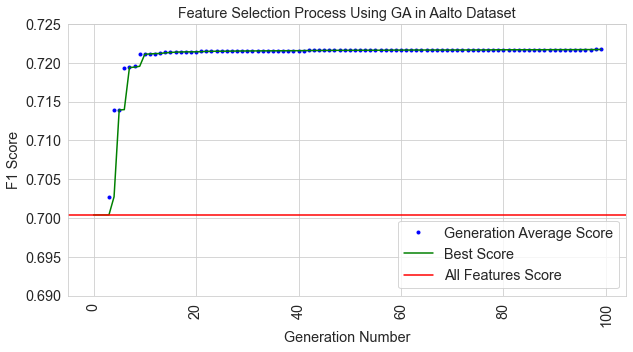

In [29]:
sns.set_style("whitegrid")
graph_name="100feature selection merge using genetic algorithm.pdf"
my_xticks=list(range(len(aalto)))
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#plt.figure(figsize=(10,10))
#plt.plot(my_xticks,tt['Acc'], linestyle='--', marker='.', color='b',label= "Separate Train & Test acc")
#plt.plot(my_xticks,cv['Acc'], linestyle='--', marker='.', color='r',label= "10-Fold CV acc")


plt.plot(my_xticks,aalto[' F1-score'], linestyle='', marker='.', color='b',label= "Generation Average Score")
plt.plot(my_xticks,best_scores_aalto, linestyle='-', marker='', color='g',label= "Best Score")

#plt.plot(my_xticks,mean_of_gean, linestyle='-', marker='', color='r',label= "Best Score")
#plt.plot(my_xticks,cv[' F1-score'], linestyle='-', marker='o', color='b',label= "10-Fold CV F1") 
plt.axhline(all_features_score_aalto   , color='r', label= "All Features Score")## hepsi

#plt.axhline(0.7382699395282875 , color='g',  label= "F1 score using all features")
plt.title("Feature Selection Process Using GA in Aalto Dataset")
plt.legend(numpoints=1)
#plt.annotate(s='', xy=(89,0.70), xytext=(89,0.72), arrowprops=dict(arrowstyle='->'))
#plt.arrow(89,0.70, 89,0.72, head_width=0.1)
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#plt.arrow(x=89, y=0.650, dx=0, dy=0.11, width=.1)
plt.ylabel("F1 Score")
plt.xlabel("Generation Number")
plt.xticks(rotation=90) 
plt.ylim([0.69, 0.7250]) 
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)

In [1]:
chosen_Feature_set=['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy', 'Label']